In [2]:
import numpy as np
import pandas as pd
import json
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import bike_project as bp
import my_stat_fcns as my_stat

import base64
from io import BytesIO

from flask import Flask
from matplotlib.figure import Figure


## Set key variables

In [62]:
urls = {
        'Fremont' : 'https://data.seattle.gov/resource/65db-xm6k.json',
        'Ballard' : 'https://data.seattle.gov/resource/47yq-6ugv.json',
        'Capitol_Hill' : 'https://data.seattle.gov/resource/j4vh-b42a.json',
        'Central_2nd_Ave' : 'https://data.seattle.gov/resource/avwm-i8ym.json',
# no data until 2019        'Central_7th_Ave' : 'https://data.seattle.gov/resource/qfzg-zmyj.json', 
        'West_Seattle' : 'https://data.seattle.gov/resource/mefu-7eau.json',
        'I90_lid' : 'https://data.seattle.gov/resource/u38e-ybnc.json',
        'NE_Seattle' : 'https://data.seattle.gov/resource/2z5v-ecg8.json',
        'Myrtle_Edwards' : 'https://data.seattle.gov/resource/4qej-qvrz.json',
        'Spokane_Street' : 'https://data.seattle.gov/resource/upms-nr8w.json'
        }

bike_shops = {
        'Fremont' : 8,
        'Ballard' : 3,
        'Capitol_Hill' : 2,
        'Central_2nd_Ave' : 5,
#         'Central_7th_Ave' : 6,
        'West_Seattle' : 3,
        'I90_lid' : 5,
        'NE_Seattle' :6 ,
        'Myrtle_Edwards' : 3,
        'Spokane_Street' : 
}


## Function calls to prepare master datatable

#### This function call to 'r_w_bike_trips' reads externally-sourced raw data and writes one json output file per location. 

In [3]:
# No need to rerun this cell--it reads data from external sources and creates locally-stored json files. 

limit = 30000
offset = 30000

with open('data/app_token.txt', 'r') as t_file: 
    app_token = t_file.read() 

for k, v in urls.items():
    bp.r_w_bike_trips(v, k, bike_shops[k], app_token, limit, offset)

     short_date  month  year  dow  Fremont_am_peak  Fremont_other  \
820  2015-01-01      1  2015    3             48.0          615.0   
821  2015-01-02      1  2015    4            404.0          406.0   
822  2015-01-03      1  2015    5              0.0          817.0   
823  2015-01-04      1  2015    6              0.0          339.0   
824  2015-01-05      1  2015    0            693.0          437.0   

     Fremont_bike_shops  
820                   8  
821                   8  
822                   8  
823                   8  
824                   8  
     short_date  month  year  dow  Ballard_am_peak  Ballard_other  \
365  2015-01-01      1  2015    3              0.0           84.0   
366  2015-01-02      1  2015    4             17.0          362.0   
367  2015-01-03      1  2015    5              0.0          375.0   
368  2015-01-04      1  2015    6              0.0          303.0   
369  2015-01-05      1  2015    0             76.0          284.0   

     Ballard_b

#### This function call brings all locations together into one master dataframe.

In [61]:
df = bp.merge_counter_locations(urls)

#### This function call appends daily weather data.


In [5]:
weather_csv = 'data/weather.csv'
use_cols = ['DATE',"PRCP","TAVG","TMAX","TMIN"]
df = bp.add_weather(df, weather_csv, use_cols)

#### This function call adds daily summary statistics for bike trip counts.

In [6]:
df = bp.add_daily_summary_data(df, bike_shops)

## EDA

- Various views of the data were undertaken to get a sense of how bike trips for commuters and other riders differ according to number of bike shops close by where they were counted and by day of week, month, year, and weather.

### Top level analysis
- The first view was to look at average daily trip counts by location and by 'am peak' and 'other'. Note that 'other' is a proxy for non-commuter trips. It equals total trip counts minus 2x 'am peak' trip counts.

In [7]:
df_weekday = df[df['dow'] <= 4]
df_weekday.filter(regex=(".*am_peak.*")).describe()

,Fremont_am_peak,Ballard_am_peak,Capitol_Hill_am_peak,Central_2nd_Ave_am_peak,West_Seattle_am_peak,I90_lid_am_peak,NE_Seattle_am_peak,Myrtle_Edwards_am_peak,Spokane_Street_am_peak,few_am_peak_ttl,many_am_peak_ttl,am_peak_ttl
count,1200.000000,1180.000000,1157.000000,1200.000000,1180.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,1183.850833,24.613559,84.998271,305.222500,37.600847,153.342500,238.80250,411.842500,366.403333,921.375833,1881.218333,2802.594167
std,440.121054,16.393739,35.563676,180.230692,29.729927,86.507397,272.70411,172.507778,148.095851,352.942160,786.342967,1111.155698
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,15.000000,11.000000,26.000000
25%,892.500000,14.000000,66.000000,203.750000,21.000000,87.750000,139.00000,302.000000,263.750000,669.500000,1361.750000,2038.000000
50%,1194.500000,24.000000,88.000000,277.000000,34.000000,147.500000,218.50000,413.000000,360.000000,921.000000,1831.000000,2777.000000
75%,1521.250000,33.000000,111.000000,360.000000,46.000000,219.000000,333.00000,545.500000,479.250000,1206.000000,2403.000000,3653.250000
max,2285.000000,151.000000,169.000000,1211.000000,239.000000,475.000000,8191.00000,894.000000,995.000000,2156.000000,10701.000000,12156.000000


In [8]:
df.filter(regex=(".*other.*")).describe()

,Fremont_other,Ballard_other,Capitol_Hill_other,Central_2nd_Ave_other,West_Seattle_other,I90_lid_other,NE_Seattle_other,Myrtle_Edwards_other,Spokane_Street_other,few_other_ttl,many_other_ttl,other_ttl
count,1680.000000,1652.000000,1621.000000,1680.000000,1652.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000,1680.000000
mean,1106.281548,90.449153,173.135102,354.286905,36.285109,357.657738,653.385119,557.508929,290.859524,1140.045238,2471.611310,3611.656548
std,617.837965,72.239082,72.449384,250.063941,64.852928,357.834259,684.293033,424.657572,225.165469,721.837336,1655.875452,2339.719173
min,37.000000,-59.000000,-33.000000,-49.000000,-128.000000,-5.000000,-924.000000,0.000000,-4.000000,24.000000,-554.000000,-227.000000
25%,622.000000,47.000000,129.000000,211.750000,6.000000,109.000000,182.750000,216.000000,128.000000,578.000000,1202.000000,1817.250000
50%,1026.500000,79.000000,175.000000,297.000000,22.000000,256.500000,448.500000,471.500000,237.000000,1014.000000,2132.000000,3179.500000
75%,1432.500000,116.250000,220.000000,417.000000,43.000000,445.000000,876.000000,786.000000,360.000000,1486.250000,3116.250000,4604.000000
max,3805.000000,836.000000,472.000000,1957.000000,734.000000,1821.000000,4095.000000,2061.000000,1992.000000,3983.000000,8974.000000,12846.000000


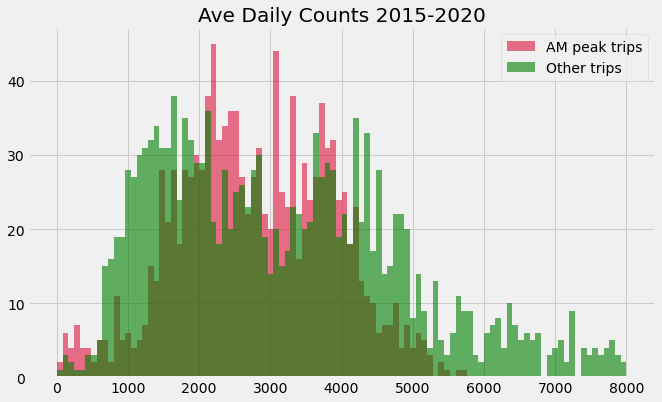

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_weekday['am_peak_ttl'], range=(1,8000), bins=100, color='crimson', label='AM peak trips', alpha=0.6);
ax.hist(df['other_ttl'], range=(1,8000), bins=100, color='green', label ='Other trips', alpha=0.6);
ax.set_title("Ave Daily Counts 2015-2020")

ax.legend()
fig.savefig('all_hist', bbox_inches='tight')


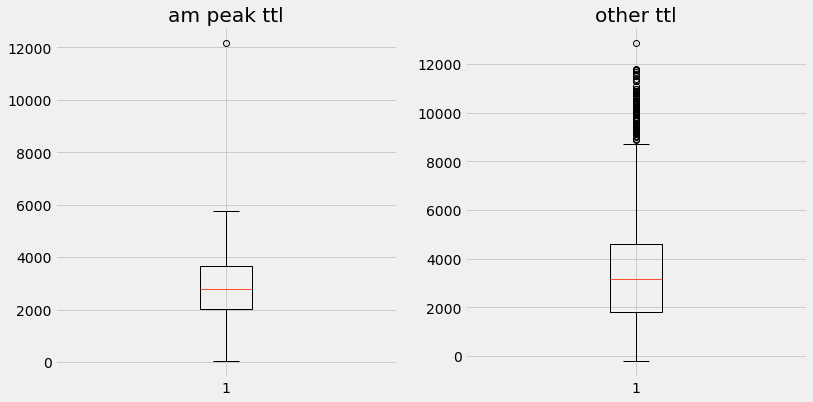

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].boxplot(df_weekday['am_peak_ttl']);
axs[1].boxplot(df['other_ttl']);
axs[0].set_title("am peak ttl")
axs[1].set_title("other ttl")
fig.savefig('all_box', bbox_inches='tight')


### Analysis of rides by day of week

In [11]:
by_dow = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl', 'year', 'month', 'dow']].groupby('dow').mean().reset_index()
# by_dow['am_peak_ttl'].replace(0, np.NaN, inplace=True)
by_dow.rename(index={0:"Monday", 1:"Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}, inplace=True)
by_dow

,dow,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl,year,month
Monday,0,2748.754167,2899.495833,907.275000,1841.479167,929.387500,1970.108333,2016.829167,6.204167
Tuesday,1,3041.533333,2845.258333,1008.450000,2033.083333,902.520833,1942.737500,2016.833333,6.183333
Wednesday,2,3014.733333,2927.204167,991.579167,2023.154167,913.633333,2013.570833,2016.833333,6.216667
Thursday,3,2758.795833,2903.229167,911.479167,1847.316667,916.841667,1986.387500,2016.816667,6.220833
Friday,4,2449.154167,2773.220833,788.095833,1661.058333,890.037500,1883.183333,2016.820833,6.208333
Saturday,5,0.000000,5555.550000,0.000000,0.000000,1724.195833,3831.354167,2016.820833,6.237500
Sunday,6,0.000000,5377.637500,0.000000,0.000000,1703.700000,3673.937500,2016.825000,6.220833


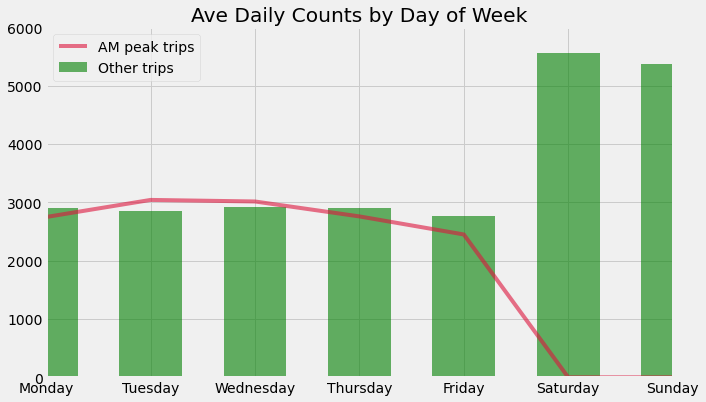

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(by_dow.index, by_dow['am_peak_ttl'], color = 'crimson', label='AM peak trips', alpha=0.6);
ax.bar(by_dow.index, by_dow['other_ttl'], color = 'green', label ='Other trips', width = 0.6, alpha=0.6);
ax.set_xlim(0,6)
ax.set_ylim(0,6000)
ax.set_title("Ave Daily Counts by Day of Week")

ax.legend();


In [13]:
by_dow_year = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl', 'year', 'month', 'dow']].groupby(['dow', 'year']).mean().reset_index()
by_dow_year['am_peak_ttl'].replace(0, np.NaN, inplace=True)
by_dow_year.head()


,dow,year,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl,month
0,0,2015,2618.076923,2989.500000,896.038462,1722.038462,974.576923,2014.923077,6.538462
1,0,2016,2659.423077,2835.480769,908.711538,1750.711538,931.096154,1904.384615,6.480769
2,0,2017,2647.692308,2619.942308,871.019231,1776.673077,817.596154,1802.346154,6.442308
3,0,2018,2735.415094,2787.471698,906.943396,1828.471698,971.000000,1816.471698,6.528302
4,0,2019,3310.129032,3516.354839,985.096774,2325.032258,967.096774,2549.258065,4.225806


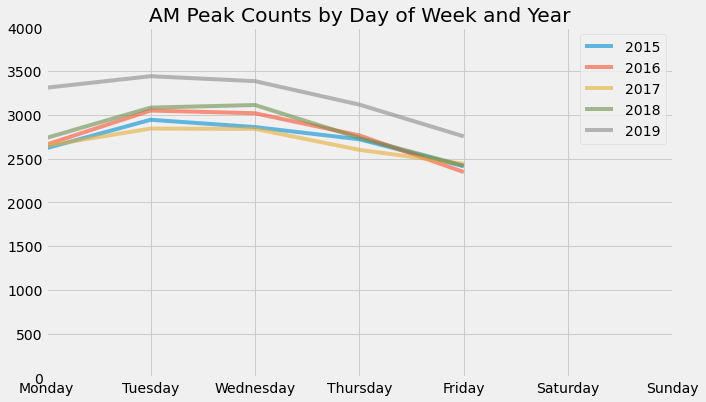

In [14]:
df['am_peak_ttl'].replace(0, np.NaN, inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))
for yr in range(2015, 2020):
    ax.plot(by_dow.index, by_dow_year[by_dow_year['year'] == yr]['am_peak_ttl'], label=f'{yr}', alpha=0.6);
    
ax.set_xlim(0,6)
ax.set_ylim(0,4000)
ax.set_title("AM Peak Counts by Day of Week and Year")
ax.legend();
    
fig.savefig('by_week_year_am_peak', bbox_inches='tight')

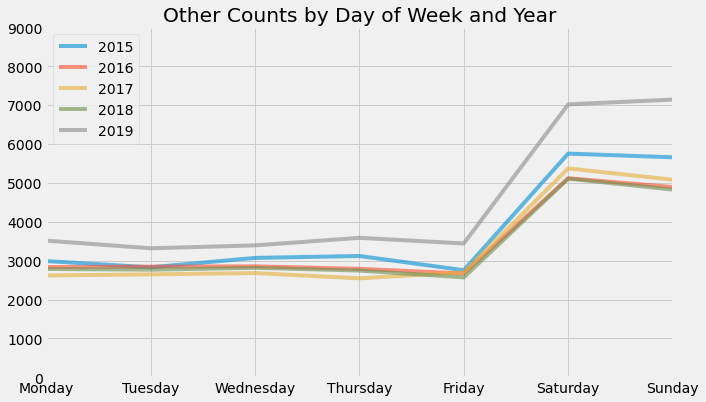

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
for yr in range(2015, 2020):
    ax.plot(by_dow.index, by_dow_year[by_dow_year['year'] == yr]['other_ttl'], label=f'{yr}', alpha=0.6);
    
ax.set_xlim(0,6)
ax.set_ylim(0,9000)
ax.set_title("Other Counts by Day of Week and Year")
ax.legend()
fig.savefig('by_week_year', bbox_inches='tight')

### Analysis of rides by month

In [16]:
by_month = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl',  'month']].groupby('month').mean().reset_index()
by_month.rename(index={0:"Jan", 1:"Feb", 2:"Mar", 3: "Apr", 4:'May', 5:"Jun", 6:"Jul", 7:"Aug", 8:"Sep", 9:"Oct", 10:"Nov", 11:"Dec"}, inplace=True)
by_month.head()

,month,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl
Jan,1,2010.612613,2153.058065,503.109677,936.748387,765.729032,1387.329032
Feb,2,1745.643564,2033.163121,425.219858,825.205674,652.198582,1380.964539
Mar,3,2204.729730,3002.367742,495.296774,1083.574194,844.032258,2158.335484
Apr,4,2777.688679,3774.500000,652.866667,1310.033333,1164.200000,2610.300000
May,5,4062.866071,5251.387097,928.877419,2006.870968,1585.419355,3665.967742


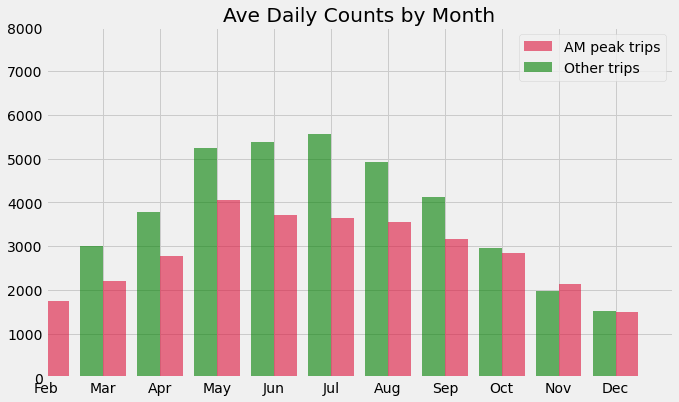

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(by_month.index, by_month['am_peak_ttl'], color = 'crimson', width=.4, align='edge', label='AM peak trips', alpha=0.6);
ax.bar(by_month.index, by_month['other_ttl'], color = 'green', label='Other trips', width=-.4, align='edge', alpha=0.6);
ax.set_xlim(1,12)
ax.set_ylim(0,8000)

ax.set_title("Ave Daily Counts by Month")
ax.legend()
fig.savefig('by_month.png', bbox_inches='tight')

In [18]:
by_year = df[['am_peak_ttl', 'other_ttl', 'few_am_peak_ttl', 'many_am_peak_ttl', 'few_other_ttl', 'many_other_ttl',  'year']].groupby('year').mean()
by_year.head()

,am_peak_ttl,other_ttl,few_am_peak_ttl,many_am_peak_ttl,few_other_ttl,many_other_ttl
year,,,,,,
2015,2711.153257,3737.726027,656.591781,1282.068493,1192.717808,2545.008219
2016,2766.061303,3432.956284,669.592896,1302.926230,1105.049180,2327.907104
2017,2674.123077,3382.852055,625.112329,1279.742466,1060.372603,2322.479452
2018,2816.869732,3373.668493,663.339726,1350.915068,1153.446575,2220.221918
2019,3204.363057,4478.178082,687.849315,1609.342466,1221.196347,3256.981735


### Analysis of rides by year

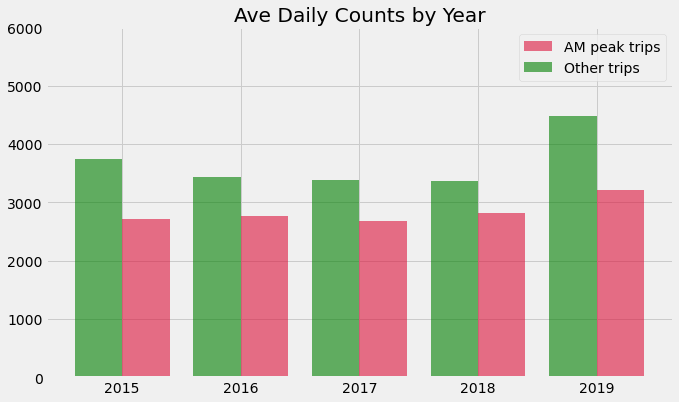

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(by_year.index, by_year['am_peak_ttl'], color = 'crimson', width=.4, align='edge', label='AM peak trips', alpha=0.6);
ax.bar(by_year.index, by_year['other_ttl'], color = 'green', width=-.4, align='edge', label='Other trips', alpha=0.6);
ax.set_ylim(0,6000)

ax.set_title("Ave Daily Counts by Year")
ax.legend()
fig.savefig('year_trend.png', bbox_inches='tight')

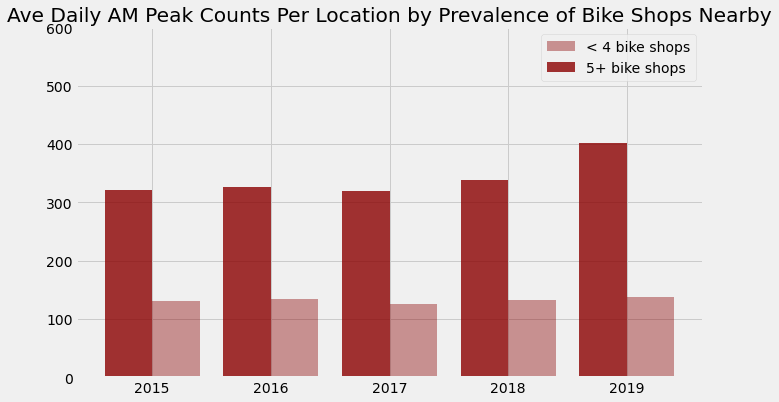

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(by_year.index, by_year['few_am_peak_ttl']/5, color = 'darkred',  width=.4, align='edge', label='< 4 bike shops', alpha=0.4);
ax.bar(by_year.index, by_year['many_am_peak_ttl']/4, color = 'darkred',  width=-.4, align='edge', label='5+ bike shops', alpha=0.8);
ax.set_ylim(0,600)

ax.set_title("Ave Daily AM Peak Counts Per Location by Prevalence of Bike Shops Nearby")
ax.legend();
fig.savefig('bike_shop_by_year.png', bbox_inches='tight')

## Data anomalies

### The NE Seattle data donut
> 5/2018 is abnormally high and 6/2018 - 8/2018 are missing.

In [21]:

NE_Seattle = df[['NE_Seattle_am_peak', 'month', 'year']].groupby(['year', 'month']).sum().reset_index()

NE_Seattle[NE_Seattle['year'] == 2018]

,year,month,NE_Seattle_am_peak
36,2018,1,3192
37,2018,2,2603
38,2018,3,3899
39,2018,4,4972
40,2018,5,16067
41,2018,6,0
42,2018,7,0
43,2018,8,0
44,2018,9,4328
45,2018,10,5289


# STATS QUESTIONS 

## ANALYSIS OF MYRTLE EDWARDS

> **Original question: Is there a statistical difference between rider counts at locations with more nearby bikeshops than fewer?** *This is obviously true based on visual inspection. Ave bike counts per counting location with 5 or more nearby bike shops are more than twice as high as counting locations with 3 or less bikeshops.*

> **New question: Even though these two groups are obviously very different, there is variation within each group. Myrtle Edwards is a location with few bike shops nearby but ride counts that resemble those of the group with more bike shops nearby. If someone were to be seeking a loan to open a bike shop in the area and wanted to be able to say in their loan request package that ride counts for this location are statistically similar to ride counts for locations with just as much traffic, would they reasonably be able to say this?**


In [54]:
df['ME_all'] = df['Myrtle_Edwards_am_peak'] + df['Myrtle_Edwards_other']
df['many_all'] = df['many_am_peak_ttl']/4 + df['many_other_ttl']/4
df['many_all'].std()/ np.sqrt(len(df['many_all']))


11.218535382890385

In [55]:
test_statistic = my_stat.welch_test_statistic(df['many_all'], df['ME_all'])
df_ME = my_stat.welch_satterhwaithe_df(df['many_all'], df['ME_all'])
students = stats.t(df_ME)

p_value = 1 - students.cdf(test_statistic)
p_value

8.802225615056614e-11

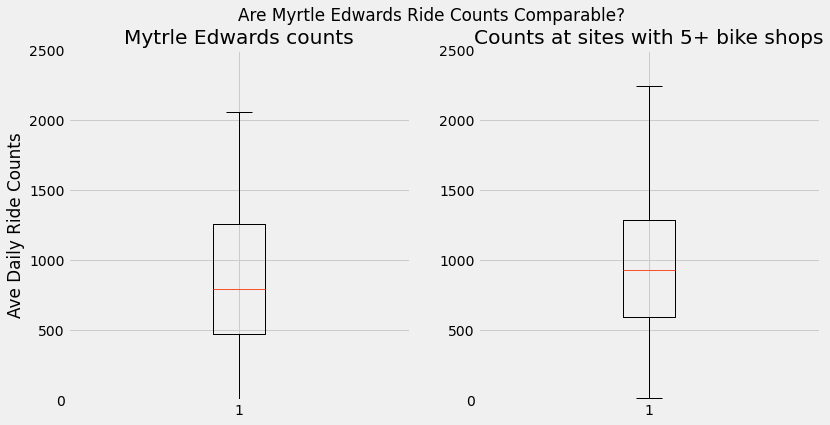

In [56]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].boxplot(df['ME_all']);
axs[1].boxplot(df['many_all'], showfliers=False);
axs[0].set_title("Mytrle Edwards counts")
axs[1].set_title("Counts at sites with 5+ bike shops")
axs[0].set_ylim(0,2500)
axs[1].set_ylim(0,2500)
axs[0].set_ylabel("Ave Daily Ride Counts")
fig.suptitle("Are Myrtle Edwards Ride Counts Comparable?")
fig.savefig('ME.png', bbox_inches='tight')

## FRIDAY RIDE COUNT STATISTICAL ANALYSIS

> **Is Friday statistically the lowest riding day of the week?**

> Null hypothesis: The mean of Friday am peak ride counts are no different than the mean ride counts from other days of the week. 

> Alt hypothesis: the mean of Friday ride counts are lower.

> alpha = 0.05

> Test with two ways. First method is t-statistic comparison of the means. Second method is bootstrap comparison of the 95% confidence intervals for each sample--Tuesday and Friday. 

In [50]:
Tuesday_counts = df_weekday[df_weekday['dow'] == 1]['am_peak_ttl']
Friday_counts = df_weekday[df_weekday['dow'] == 4]['am_peak_ttl']
Tue_mean = Tuesday_counts.mean()
Fri_mean = Friday_counts.mean()
Tue_sd = Tuesday_counts.std()
Fri_sd = Friday_counts.std()


In [51]:
test_statistic = my_stat.welch_test_statistic(Tuesday_counts, Friday_counts)
df_ = my_stat.welch_satterhwaithe_df(Tuesday_counts, Friday_counts)
students = stats.t(df_)

p_value = 1 - students.cdf(test_statistic)
p_value

5.592083462957476e-10

In [52]:
Tue_b_strap_counts = my_stat.bootstrap_sample_means(df_weekday[df_weekday['dow'] == 1]['am_peak_ttl'])
Fri_b_strap_counts = my_stat.bootstrap_sample_means(df_weekday[df_weekday['dow'] == 4]['am_peak_ttl'])
# Tue_b_strap_mean = Tuesday_counts['am_peak_ttl'].mean()
# Fri_b_strap_mean = Friday_counts['am_peak_ttl'].mean()


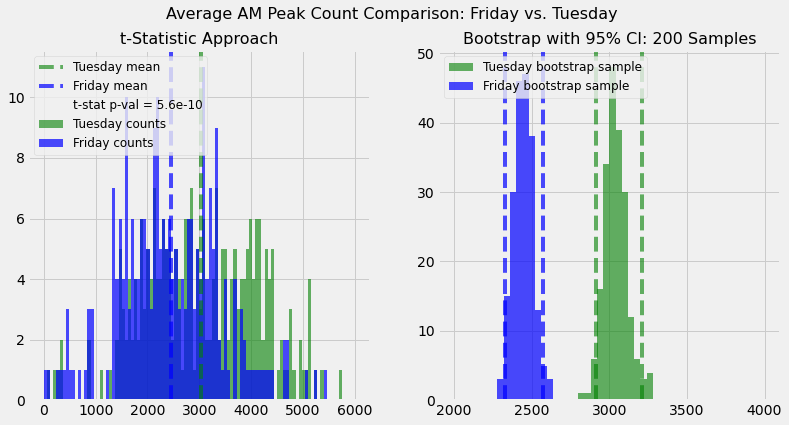

In [53]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))
fig.suptitle('Average AM Peak Count Comparison: Friday vs. Tuesday', fontsize=16)
ax[0].hist(Tuesday_counts, range=(1,6000), bins=100, color='green', label='Tuesday counts', alpha=0.6);
ax[0].hist(Friday_counts, range=(1,6000), bins=100, color='blue', label='Friday counts', alpha=0.7);
ax[0].set_title("t-Statistic Approach", fontsize=16)
ax[0].axvline(Tue_mean, color='green', linestyle='--', alpha=0.6, label='Tuesday mean')
ax[0].axvline(Fri_mean, color='blue', linestyle='--', alpha=0.7, label='Friday mean')
ax[0].axvline(Fri_mean+10, color='blue', linestyle='--', alpha=0.0, label=f't-stat p-val = {p_value:.2}')
ax[0].legend(loc="upper left", prop={'size': 12});

ax[1].hist(Tue_b_strap_counts, range=(2000,4000), bins=50, color='green', label='Tuesday bootstrap sample', alpha=0.6);
ax[1].hist(Fri_b_strap_counts, range=(2000,4000), bins=50, color='blue', label='Friday bootstrap sample', alpha=0.7);
ax[1].set_title("Bootstrap with 95% CI: 200 Samples", fontsize=16)
ax[1].axvline(np.percentile(Tue_b_strap_counts, 2.5), color='green', linestyle='--', alpha=0.6)
ax[1].axvline(np.percentile(Tue_b_strap_counts, 97.5), color='green', linestyle='--', alpha=0.6)
ax[1].axvline(np.percentile(Fri_b_strap_counts, 2.5), color='blue', linestyle='--', alpha=0.7)
ax[1].axvline(np.percentile(Fri_b_strap_counts, 97.5), color='blue', linestyle='--', alpha=0.7)
ax[1].legend(loc="upper left", prop={'size': 12});
fig.savefig('Tue_vs_Fri.png', bbox_inches='tight')

## 2019 RIDE COUNT INCREASE AND POWER CURVES

In [57]:
Incr_2019 = (df[df['year'] == 2019]['am_peak_ttl'].mean() - df[df['year'] <= 2018]['am_peak_ttl'].mean()) / df[df['year'] <= 2018]['am_peak_ttl'].mean()
Incr_2019

0.16857270935452692

In [58]:
df[df['year'] <= 2018]['am_peak_ttl'].mean()

2742.116970278044

In [59]:
mu0 = df[df['year'] <= 2018]['am_peak_ttl'].mean()
st_dev = df[df['year'] <= 2018]['am_peak_ttl'].std()
alpha = 0.05
samps_arr = [60, 120, 180, 240]
effect_range = range(2650, 3400, 10)
samps_dict = {}
for samps in samps_arr:
    power_arr = []
    for effect in effect_range:
        power_arr.append(my_stat.compute_power(samps, st_dev, alpha, mu0, effect))
    samps_dict[samps] = power_arr


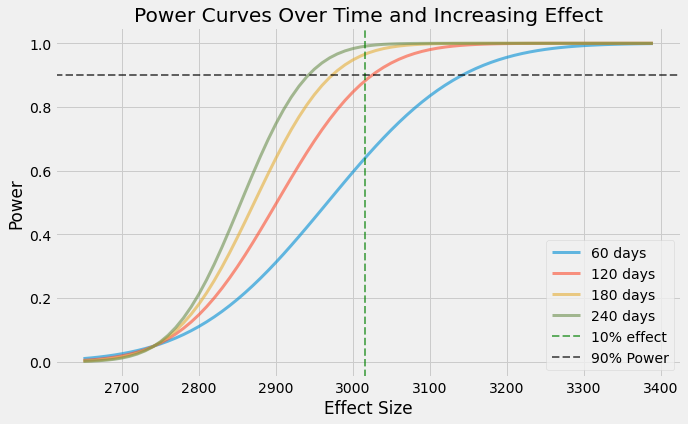

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))
for samps in samps_arr:
    ax.plot(effect_range, samps_dict[samps], label=f'{samps} days', lw=3, alpha=0.6);


ax.axvline(mu0*1.1, color='green', label='10% effect', linestyle='--', lw= 2, alpha=0.6)
ax.axhline(0.9, color='black', label='90% Power', linestyle='--', lw=2, alpha=0.6)
ax.set_xlabel("Effect Size")
ax.set_ylabel("Power")
ax.set_title("Power Curves Over Time and Increasing Effect")
ax.legend()
fig.savefig('power_curves.png', bbox_inches='tight')

### Analysis of rides by weather

In [37]:
weather_by_time_of_trip = df[['am_peak_ttl', 'other_ttl', 'year', 'month', 'dow', 'PRCP', 'TAVG', 'TMIN', "TMAX"]]

In [ ]:
fig, axs = plt.subplots(4, 2, figsize = (16, 12))

for i in range(4):
    for j in range(2):
        axs[i][j].scatter(weather_by_time_of_trip.iloc[:,j], weather_by_time_of_trip.iloc[:, i+5], alpha=0.5)
        
# ax.plot(by_year['year'], by_year['many_am_peak_ttl']/3, color = 'red', label='More bike shops', alpha=0.6);
# ax.set_xlim(2015, 2019)
# ax.set_ylim(0,300)
